<a href="https://colab.research.google.com/github/charlesdgburns/NM_TinyRNN/blob/main/notebooks/nm_tinyrnn_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Let's use this as a learning notebook about different RNN mechanics - how do they solve the reversal learning task?

Here we are studying networks that have been pre-trained and selected (see the notebook `train_and_select_RNNs`).

These example networks should be stored in an `example` subfolder (if you've cloned the git)

In [16]:
## setup on google colab:

!git clone https://github.com/charlesdgburns/NM_TinyRNN.git
from pathlib import Path
CODE_DIR = Path('.')
SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'


fatal: destination path 'NM_TinyRNN' already exists and is not an empty directory.


In [17]:
# set paths not on google colab
from pathlib import Path
import os
#CODE_DIR = Path(Path(r'.'))
#os.chdir(CODE_DIR)
CODE_DIR = Path('.')
DATA_PATH = CODE_DIR/'NM_TinyRNN/data'
EXAMPLE_PATH = DATA_PATH/'rnns/example'


In [18]:
# Import packages and local code
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from NM_TinyRNN.code.models import training
from NM_TinyRNN.code.models import datasets
from NM_TinyRNN.code.models import rnns
from NM_TinyRNN.code.measures import analysis
from importlib import reload #for active development


In [19]:
# let's load all our models and data !
# you can substitute EXAMPLE_PATH for any subject-level folder
reload(analysis)
model_dict = {}
for model_type_dir in EXAMPLE_PATH.iterdir():
    model_ids = [x.stem[:-5] for x in model_type_dir.iterdir() if '_info' in x.stem]
    for model_id in model_ids:
        filepaths = [x for x in model_type_dir.iterdir() if model_id in x.stem]
        data_dict = {}
        for data_type in ['model_state','info','trials_data','training_losses']:
            filepath = [f for f in filepaths if data_type in f.stem][0]
            data_dict[data_type] = analysis.load_data(str(filepath)) 
        model_dict[model_id] = data_dict
        
# in future we probably want a nifty class that does a lot of utility for us. 
# this will have to do for now :)

/tmp/ipykernel_122136/1392164244.py:26: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


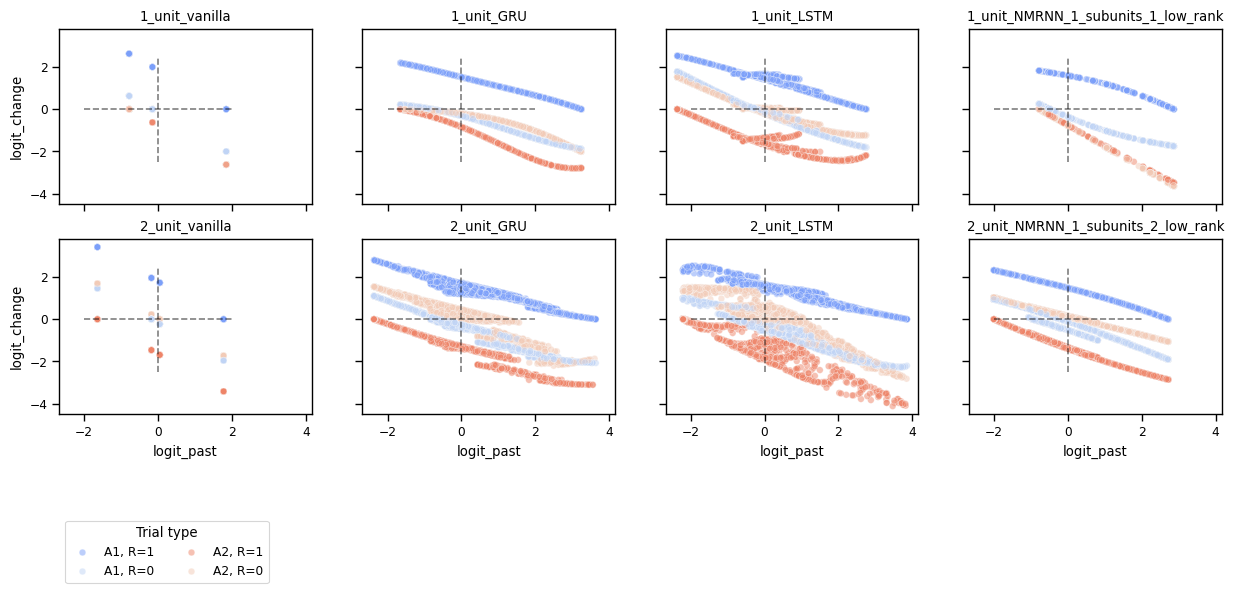

In [20]:
# plotting logits for 1 unit and 2 unit standard architectures
plot_ids = ['1_unit_vanilla','1_unit_GRU','1_unit_LSTM','1_unit_NMRNN_1_subunits_1_low_rank',
             '2_unit_vanilla','2_unit_GRU','2_unit_LSTM','2_unit_NMRNN_1_subunits_2_low_rank']

fig, axes = plt.subplots(2,4, figsize = (15,5), sharex=True, sharey=True)
flat_ax = axes.flatten()

palette = sns.color_palette('coolwarm',4)
palette[2],palette[3] = palette[3], palette[2] #reordercolorpalette
for i,each_model in enumerate(plot_ids):
    df = model_dict[each_model]['trials_data']
    sns.scatterplot(df, x='logit_past',y='logit_change',hue='trial_type',
                    palette=palette ,ax=flat_ax[i], alpha  = 0.5,)
    flat_ax[i].set(title = f'{each_model}')
    flat_ax[i].vlines(x=0,ymin=-2.5,ymax=2.5, 
                      linestyle = '--', color = 'black',alpha =0.5)
    flat_ax[i].hlines(y=0, xmin=-2,xmax=2,
                      linestyle = '--', color = 'black',alpha =0.5)
    if i==0:
        sns.move_legend( flat_ax[i], "lower left",
                        bbox_to_anchor=(0.0, -2.2), ncol=2, 
                        title='Trial type', frameon=True, )
    else:
        flat_ax[i].get_legend().remove()
        
fig.tight_layout()

**Figure: logit plots of standard architectures**. Here we may interpret the logit as the belief state of each model (what choice is good?). For each model architecture and dimensionality, we plot the change in logit as a function of the past logit, coloured by trial type. We also plot vertical and horizontal striped lines to indicate the 0 axes. Note that points crossing the horizontal axis are by definition fixed points since the change in logit is 0 here. *All architecures discover a choice bias, but the discovered cognitive strategy depends on the architecture.*


Below, we dive deeper into the different strateies of each model, looking at weights, and hidden activations of gates. We hope to reach an understanding of the mechanisms each model uses to predict the animals choices.

## Vanilla RNNs

recall that these are the simplest RNN goverened by:

$$h_t = W_{ih}x_{t-1}+b_i+W_{hh}h_{t-1}+b_h $$

here $h_t$ is decoded to predict the mouse's upcoming choice in a 2 armed bandit task.
We can map this choice onto a 1 dimensional 'logit' value, which represents the odds of choosing either left or right.

### 1D

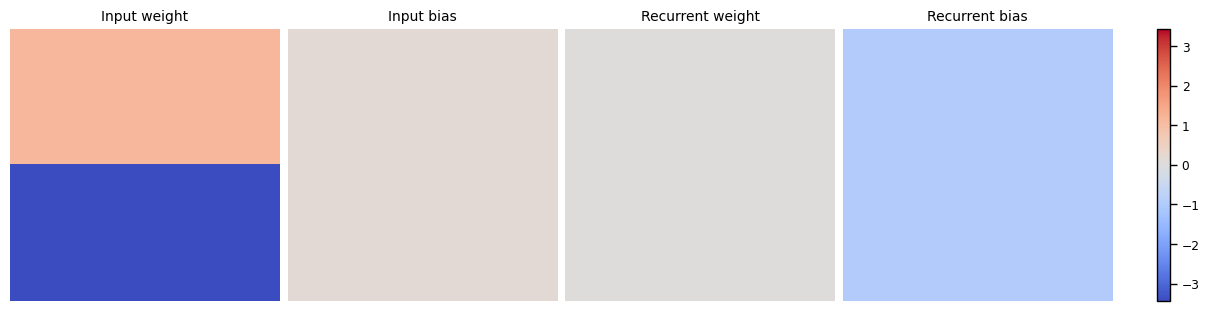

In [21]:
import matplotlib.pyplot as plt

weights = model_dict['1_unit_vanilla']['model_state']

mats = [
    weights['rnn.weight_ih_l0'].T,  # input → hidden
    weights['rnn.bias_ih_l0'][None, :],  # input bias (make 2D for imshow)
    weights['rnn.weight_hh_l0'].T,  # hidden → hidden
    weights['rnn.bias_hh_l0'][None, :],  # recurrent bias
]

titles = ["Input weight", "Input bias", "Recurrent weight", "Recurrent bias"]

# determine global vmin/vmax for consistent color scale
all_vals = np.concatenate([m.ravel() for m in mats])
vmin, vmax = -np.abs(all_vals).max(), np.abs(all_vals).max()

fig, axes = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True)

ims = []
for ax, mat, title in zip(axes, mats, titles):
    im = ax.imshow(mat, aspect="auto", vmin=vmin, vmax=vmax, cmap="coolwarm")
    ax.set_title(title, fontsize=10)
    ax.axis("off")
    ims.append(im)

# shared colorbar
fig.colorbar(ims[0], ax=axes, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()


recall that the inputs are ordered as `outcome` then `choice`.

We can consider the behaviour in terms of the four trial types. 

For example, **if `choice` is 0** the input weight needs to balance out with the sum of the biases (which it does) whenever there's a positive outcome. Otherwise, the biases need to move the network to a fixed point between the two choices. If there's two negative outcomes in a row, the network stays at a fixed point, exactly where $W_{hh}h_{t-1}$ is equal to the biases.

**if `choice` is 1** the input weights drag the network to a negative state when outcome is $0$. If there is a negative outcome again, it might still be dragged further down. To know for sure, we can take another look at the logit readout of the hidden state below.

<Axes: xlabel='trial_type', ylabel='logit_past'>

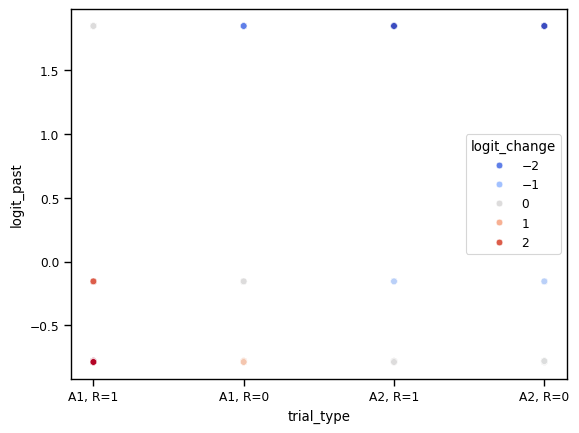

In [22]:
# here's an alternate view of the logit plot. 
# Here we more clearly see the three possible hidden states, 
# and how the trial type affects the hidden state (depending on the past state/logit)
trials_df = model_dict['1_unit_vanilla']['trials_data']
sns.scatterplot(trials_df,x='trial_type', y='logit_past', 
                hue='logit_change', palette='coolwarm')

Alternate view of logit plot makes the bias towards A1 very clear: even if unrewarded, if the network is in the uncertain state, it is still more likely to choose A1 and will stay in this uncertain state even if unrewarded.

<Axes: xlabel='None', ylabel='good_poke'>

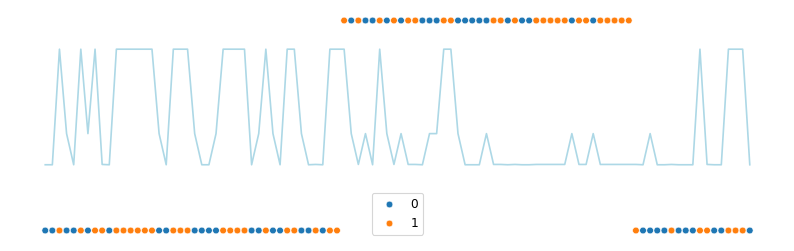

In [23]:
#We can see the model's behaviour in action. 
# Plotting a scatter for which side is the 'good poke', colored by outcome
# also plotting the probability of choosing one of the pokes.
trials_df = model_dict['1_unit_vanilla']['trials_data']
plot_df = trials_df.iloc[5000:5100]
fig, ax = plt.subplots(figsize=(10,3))
ax.axis('off')
sns.scatterplot(plot_df, x = plot_df.index, y='good_poke',hue='outcome', 
                ax = ax)
sns.lineplot(plot_df, x = plot_df.index, y='prob_A',c='lightblue', ax = ax)


## Gated Recurrent Units

Recall that they are governed by the following equations:

\begin{align}
r_t &= \sigma(W_{ir}x_{t-1}+W_{hr}h_{t-1}+b_{r})  &&\text{(reset gate)} \\
z_t &= \sigma(W_{iz}x_{t-1}+W_{hz}h_{t-1}+b_{z})  &&\text{(update gate)} \\
n_t &= \tanh(W_{in}x_{t-1}+b_{in}+r_{t}\cdot (W_{hn}h_{t-1}+b_{hn})) &&\text{(new state)}
\\
h_t &= (1-z_t)\cdot h_{t-1} +z_t \cdot n_t &&\text{(hidden state)}
\end{align}


### 1D

In [24]:
# Look at some weights? This might be hard to understand / read.


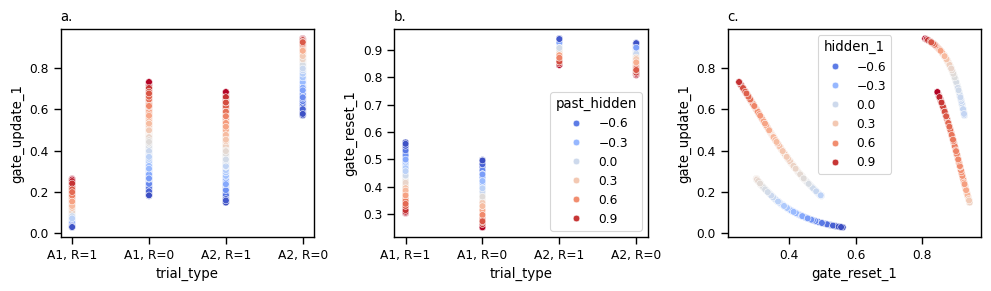

In [25]:
# Recall that the AB task has 4 trial types. Let's look at gate activations for each
# again we will use the logit as a linear readout of hidden state
sns.set_context('paper')
trials_df = model_dict['1_unit_GRU']['trials_data']
fig, ax = plt.subplots(1,3, figsize=(10,3))

trials_df['past_hidden'] = np.concatenate([[np.nan],trials_df.hidden_1.values[:-1]])

sns.scatterplot(trials_df,x='trial_type',y='gate_update_1',
                hue='past_hidden', ax = ax[0], palette='coolwarm',
                legend=False)
sns.scatterplot(trials_df,x='trial_type',y='gate_reset_1',
                hue='past_hidden', ax = ax[1], palette='coolwarm')
sns.scatterplot(trials_df,x='gate_reset_1',y='gate_update_1',
                hue='hidden_1', palette='coolwarm', ax = ax[2])
[ax[i].set_title(f'{x}', loc='left') for i,x in enumerate(['a.','b.','c.'])]
fig.tight_layout()

**Figure:** gate activations as a function of $h_{t-1}$ (hue) and $x_t$ (trial type). **a.** the update gate is sensitive to reward, with higher update values for unrewarded trials. Here we also notice a choice bias to update less for trials on the A1 side. **b.** the reset gate is sensitive to choice, with larger reset values for A2 choices regardless of outcome. **c.** we plot how the update gate and reset gate relates to the upcoming hidden state (given by hue). Note that the division across reset gate values is caused by the choice bias.

### 2D

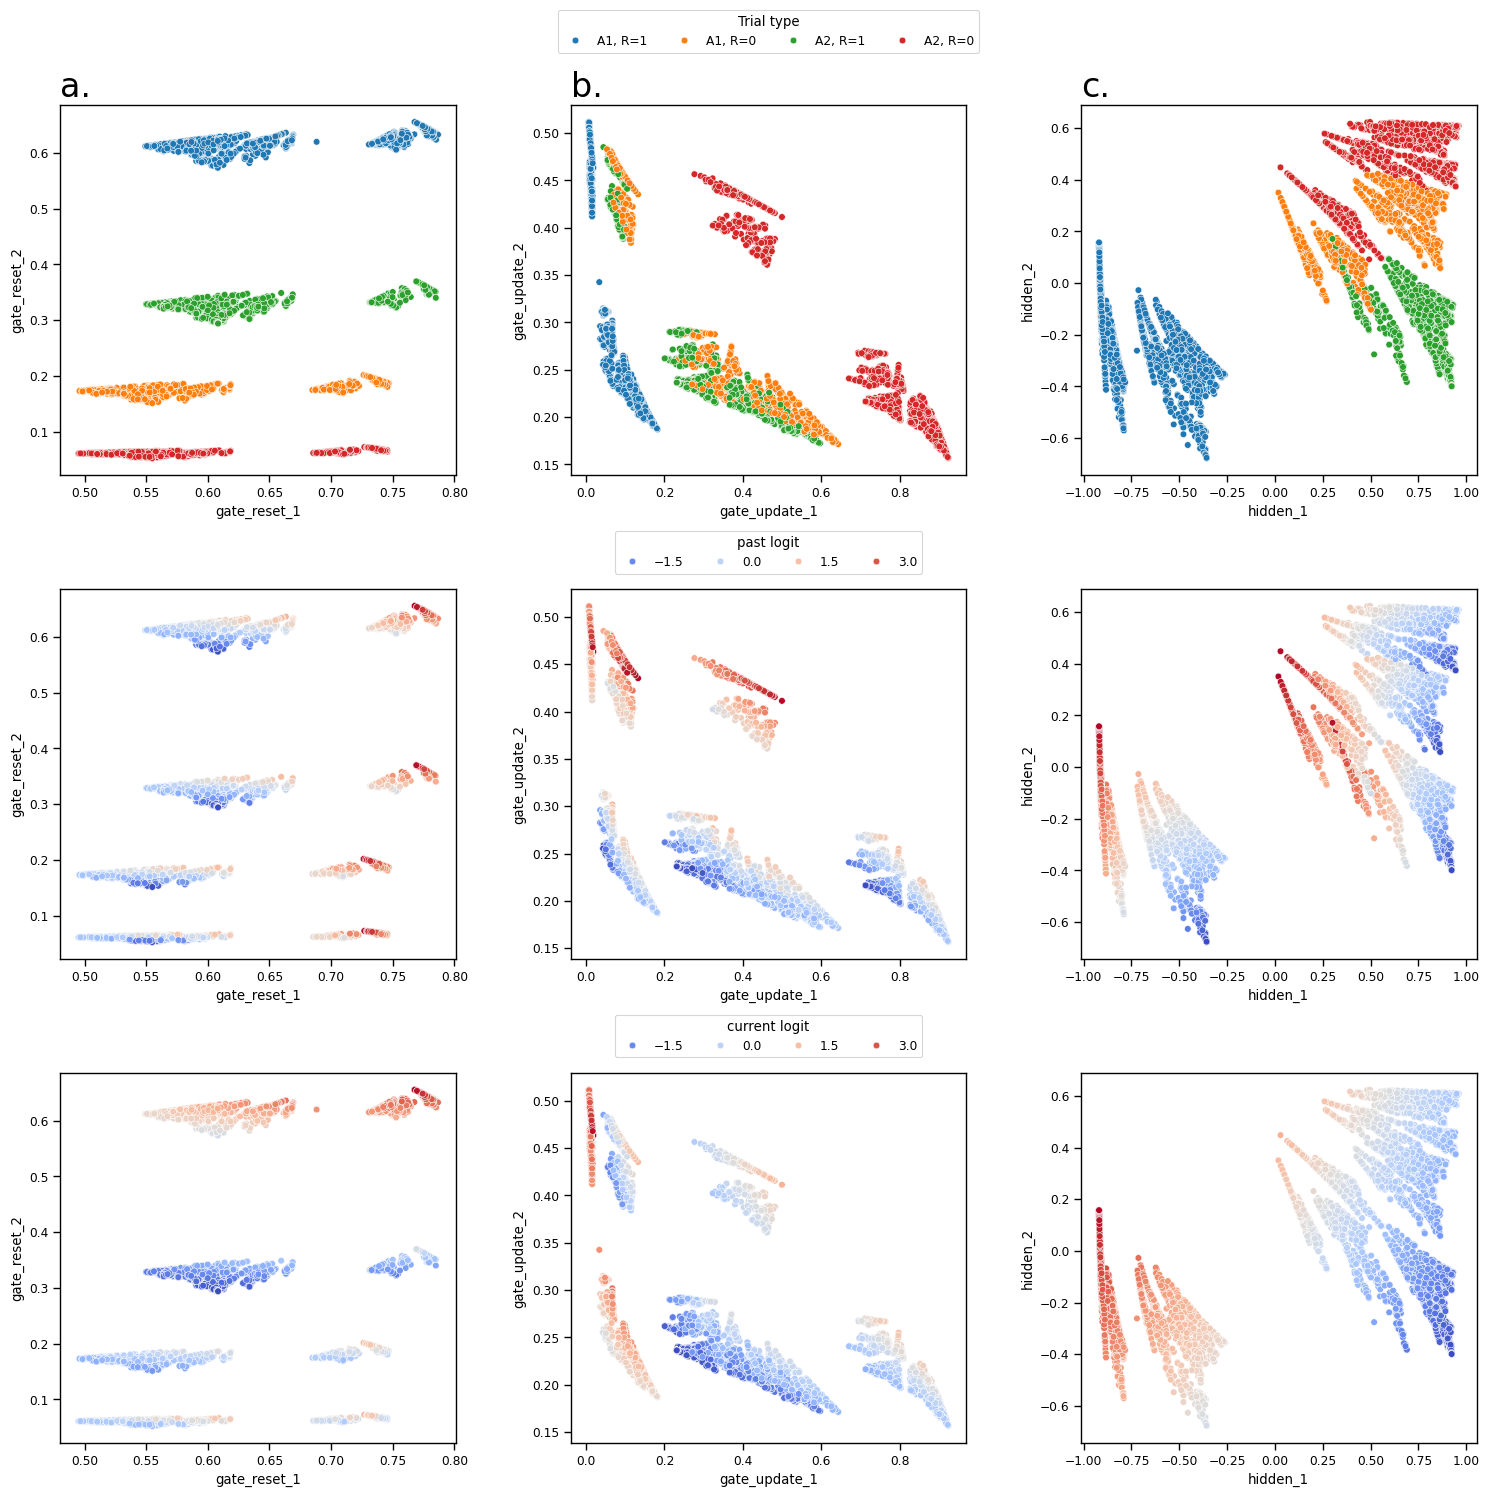

In [26]:
# My thought is to visualise the stable points similarly in 2D plots
trials_df = model_dict['2_unit_GRU']['trials_data']

fig, ax = plt.subplots(3,3, figsize = (15,15))
flat_ax = ax.flatten()
sns.scatterplot(trials_df, x='gate_reset_1',y='gate_reset_2', 
                hue='trial_type', ax = flat_ax[0])
sns.scatterplot(trials_df, x='gate_update_1',y='gate_update_2', 
                hue='trial_type',ax = flat_ax[1])
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2', 
                hue='trial_type',ax = flat_ax[2])

sns.scatterplot(trials_df, x='gate_reset_1',y='gate_reset_2', 
                hue='logit_past',palette='coolwarm', ax = flat_ax[3])
sns.scatterplot(trials_df, x='gate_update_1',y='gate_update_2', 
                hue='logit_past',palette='coolwarm',ax = flat_ax[4])
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2', 
                hue='logit_past',palette='coolwarm',ax = flat_ax[5])

sns.scatterplot(trials_df, x='gate_reset_1',y='gate_reset_2', 
                hue='logit_value',palette='coolwarm', ax = flat_ax[6])
sns.scatterplot(trials_df, x='gate_update_1',y='gate_update_2', 
                hue='logit_value',palette='coolwarm', ax = flat_ax[7])
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2', 
                hue='logit_value',palette='coolwarm', ax = flat_ax[8])

for i, title in enumerate(['a.','b.','c.','','','','','','']):
    flat_ax[i].set_title(title, loc='left', fontsize=24)
    if i == 1:
        sns.move_legend(flat_ax[i], "center",
                        bbox_to_anchor=(0.5, 1.2), ncol=4, 
                        title='Trial type', frameon=True, )
    elif i == 4:
        sns.move_legend(flat_ax[i], "center",
                        bbox_to_anchor=(0.5, 1.1), ncol=4, 
                        title='past logit', frameon=True, )
    elif i == 7:
        sns.move_legend(flat_ax[i], "center",
                        bbox_to_anchor=(0.5, 1.1), ncol=4, 
                        title='current logit', frameon=True, )
    else:
        flat_ax[i].get_legend().remove()
fig.tight_layout()

**Figure: gate and hidden state dependence on $x_t$ (trial type) and $h_{t+1}$ (past hidden)**. **a.** The reset gates have orthogonalised roles; gate 2 clearly tracks trial type (top) and gate 1 is aligned with past hidden (bottom). **b.** Update gate 1 is aligned with outcome (top) an d, nonlinearly with outcome and with a side bias. Not yet clear what update gate 2 tracks (see below). **c.** Hidden 1 tracks whether it is being rewarded at A1, and the hidden 2 seems to track choice nonlinearly (joint with hidden 1).

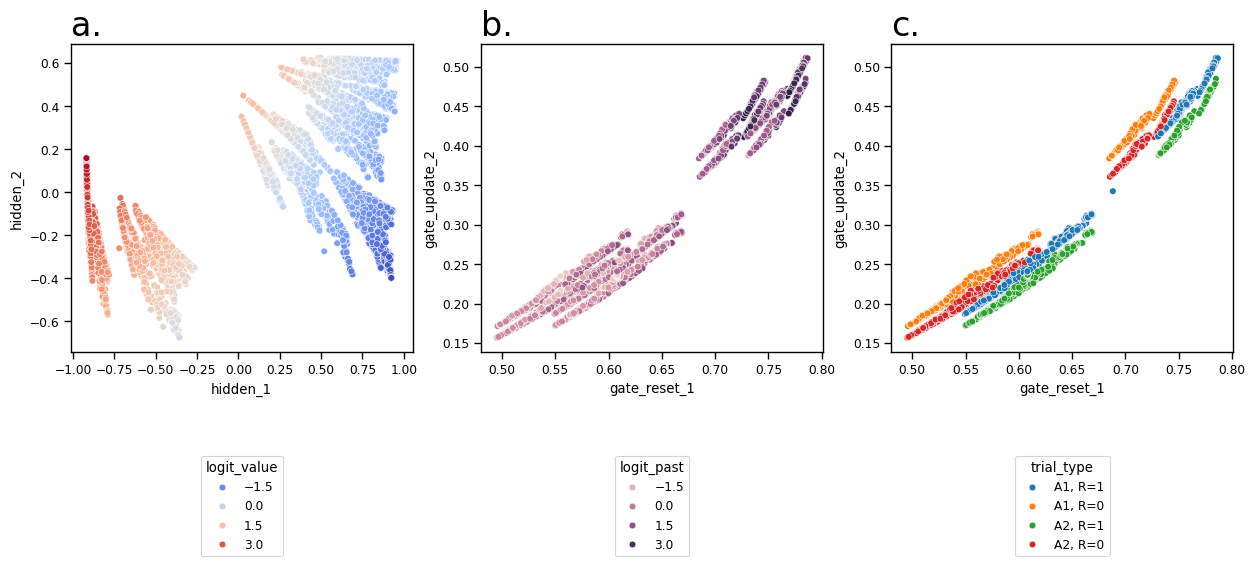

In [27]:
# not clear what gate_reset_1 or gate_update_2 are tracking, 
# nor how belief state is distributed between hidden_1 and hidden_2

# My thought is to visualise the stable points similarly in 2D plots
trials_df = model_dict['2_unit_GRU']['trials_data']
fig, ax = plt.subplots(1,3, figsize = (15,4))
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2', 
                hue='logit_value',palette='coolwarm',ax = ax[0])

sns.scatterplot(trials_df, x='gate_reset_1',y='gate_update_2', 
                hue='logit_past', ax = ax[1])
sns.scatterplot(trials_df, x='gate_reset_1',y='gate_update_2', 
                hue='trial_type',ax = ax[2])

for i, title in enumerate(['a.','b.','c.']):
    ax[i].set_title(title, loc='left', fontsize=24)
    sns.move_legend(ax[i], "center",
                    bbox_to_anchor=(0.5, -0.5))
    
#fig.tight_layout()

**Figure: gate activations and hidden state jointly code for current and past belief state.** **a.** current belief state (logit) is jointly coded by hidden state 1 and 2 along a diagonal from top left to lower right. **b.,c.** past belief state is tracked by both reset gate 1 and update gate 2, with variance explained by trial type aligned with outcome.   

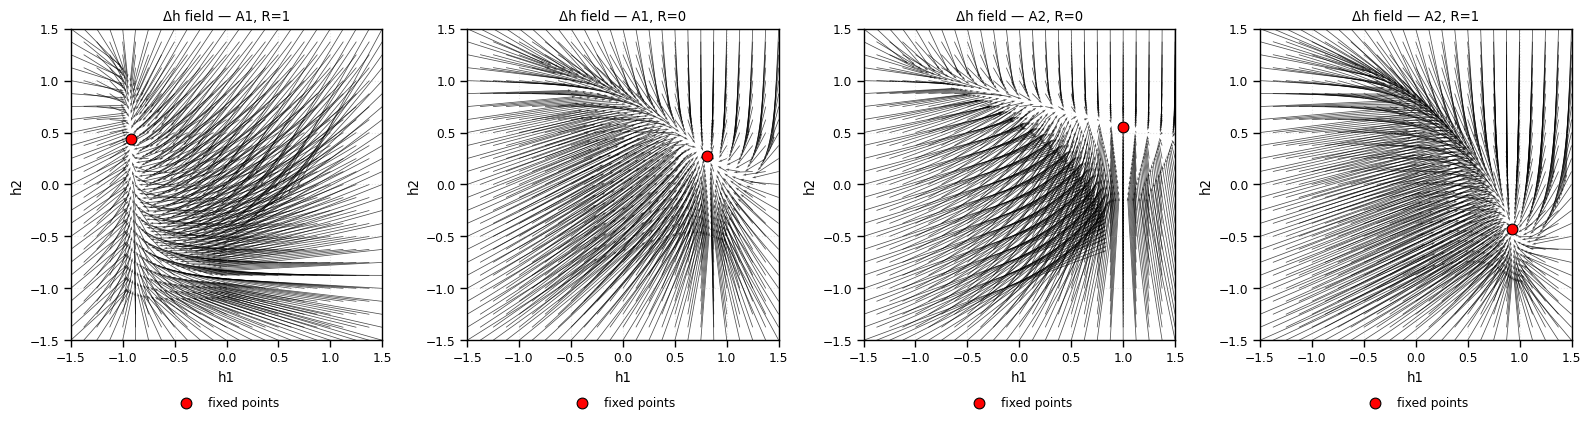

In [28]:
### can we maybe plot the recurrent dynamics?

weights = model_dict['2_unit_GRU']['model_state']

def unpack_gru_params(weights):
    """
    Unpack concatenated GRU weights/biases for gates (r, z, n).
    Expects keys like:
      f"{prefix}.weight_ih_l{layer}", f"{prefix}.weight_hh_l{layer}",
      f"{prefix}.bias_ih_l{layer}", f"{prefix}.bias_hh_l{layer}"
    Shapes (PyTorch): [3*H, I] and [3*H, H], biases [3*H]
    Order: r, z, n (reset, update, new)
    """
    Wi = weights['rnn.W_from_in'].detach().cpu().numpy().T  # (3H, I)
    Wh = weights['rnn.W_from_h'].detach().cpu().numpy().T  # (3H, H)
    H = Wh.shape[1] #number of units
    bi = weights['rnn.bias'][:3*H].detach().cpu().numpy()
    bh = weights['rnn.bias'][3*H:].detach().cpu().numpy()

    # slice per gate
    def split3(M):
        return M[0:H], M[H:2*H], M[2*H:3*H]
    Wi_r, Wi_z, Wi_n = split3(Wi)
    Wh_r, Wh_z, Wh_n = split3(Wh)
    bi_r, bi_z, bi_n = split3(bi)
    bh_r, bh_z, bh_n = split3(bh)

    # combine biases (PyTorch uses both ih and hh biases)
    br = bi_r + bh_r
    bz = bi_z + bh_z
    bn = bi_n + bh_n

    return dict(Wi_r=Wi_r, Wi_z=Wi_z, Wi_n=Wi_n,
                Wh_r=Wh_r, Wh_z=Wh_z, Wh_n=Wh_n,
                br=br, bz=bz, bn=bn)


def gru_step(h, u, P):
    """
    One GRU step (numpy) with constant input u.
    h: (H,), u: (I,), P: dict from unpack_gru_params
    """
    def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))
    Wi_r, Wi_z, Wi_n = P["Wi_r"], P["Wi_z"], P["Wi_n"]
    Wh_r, Wh_z, Wh_n = P["Wh_r"], P["Wh_z"], P["Wh_n"]
    br, bz, bn = P["br"], P["bz"], P["bn"]

    r = sigmoid(Wi_r @ u + Wh_r @ h + br)
    z = sigmoid(Wi_z @ u + Wh_z @ h + bz)
    n = np.tanh(Wi_n @ u + (Wh_n @ (r * h)) + bn)
    h_next = (1 - z) * n + z * h
    return h_next

def delta_field(h, u, P):
    """Return Δh = GRU(h,u) - h."""
    return gru_step(h, u, P) - h

# ---------- Fixed points for discrete-time GRU ----------
def find_fixed_points(P, u, inits, max_iter=500, tol=1e-6, alpha=1.0):
    """
    Simple fixed-point iteration: h_{k+1} = (1-alpha)*h_k + alpha*GRU(h_k,u)
    alpha in (0,1] can help convergence (under-relaxation).
    Returns unique converged points.
    """
    H = P["Wh_r"].shape[1]
    sols = []
    for h0 in inits:
        h = h0.copy()
        for _ in range(max_iter):
            h_new = (1 - alpha) * h + alpha * gru_step(h, u, P)
            if np.linalg.norm(h_new - h) < tol:
                break
            h = h_new
        # de-duplicate
        if np.linalg.norm(gru_step(h, u, P) - h) < 5*tol:
            if not any(np.linalg.norm(h - s) < 1e-3 for s in sols):
                sols.append(h)
    return np.stack(sols) if len(sols) else np.zeros((0, H))

# ---------- Plotting ----------
def plot_quiver_for_inputs(state_dict, inputs_dict, 
                           grid_lim=1.5, grid_n=25,
                         show_fixed_points=True):
    """
    inputs_dict: {name: u_vector} where u_vector has shape (I,)
    Makes a row of quiver plots of Δh for each fixed input (trial type).
    """
    P = unpack_gru_params(state_dict)
    H = P["Wh_r"].shape[1]
    assert H == 2, "This plotting helper expects a 2-unit GRU (H=2)."

    # grid on hidden state space
    xs = np.linspace(-grid_lim, grid_lim, grid_n)
    ys = np.linspace(-grid_lim, grid_lim, grid_n)
    X, Y = np.meshgrid(xs, ys)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    n_cols = len(inputs_dict)
    fig, axes = plt.subplots(1, n_cols, figsize=(4*n_cols, 4), squeeze=False)
    axes = axes[0]

    for ax, (name, u_vec) in zip(axes, inputs_dict.items()):
        # compute vector field
        for i in range(grid_n):
            for j in range(grid_n):
                h = np.array([X[i, j], Y[i, j]])
                d = delta_field(h, u_vec, P)
                U[i, j], V[i, j] = d[0], d[1]

        ax.quiver(X, Y, U, V, angles="xy", scale_units="xy", scale=1.0, alpha=0.7)
        ax.set_title(f"Δh field — {name}")
        ax.set_xlabel("h1")
        ax.set_ylabel("h2")
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(-grid_lim, grid_lim)
        ax.set_ylim(-grid_lim, grid_lim)
        ax.grid(True, ls=":", alpha=0.3)

        if show_fixed_points:
            # seed fixed-point solver from a coarse grid
            seeds = []
            for x in np.linspace(-1.2, 1.2, 7):
                for y in np.linspace(-1.2, 1.2, 7):
                    seeds.append(np.array([x, y], dtype=float))
            fps = find_fixed_points(P, u_vec, seeds, alpha=0.7)
            if len(fps):
                ax.scatter(fps[:,0], fps[:,1], s=60, marker="o", edgecolor="k", facecolor="red", zorder=5, label="fixed points")
                ax.legend(loc="center", 
                          bbox_to_anchor=(0.5, -0.2),
                          frameon=False)

    fig.tight_layout()
    return fig, axes

# ---------- Example usage ----------
# Assume you have a 2-unit, 1-layer GRU stored in:
weights = model_dict['2_unit_GRU']['model_state']
# And trial-type constant inputs like:

input_dict = {'A1, R=1':np.array([1,0]),
              'A1, R=0':np.array([0,0]),
              'A2, R=0':np.array([0,1]),
              'A2, R=1':np.array([1,1])}

fig, axes = plot_quiver_for_inputs(weights, input_dict, 
                                   grid_lim=1.5, grid_n=25,
                                   show_fixed_points=True)
plt.show()

(<Figure size 2000x600 with 4 Axes>,
 [<Axes3D: title={'center': 'A1, R=1'}, xlabel='h1', ylabel='h2', zlabel='$E(h)=\\|\\Delta h\\|$'>,
  <Axes3D: title={'center': 'A1, R=0'}, xlabel='h1', ylabel='h2', zlabel='$E(h)=\\|\\Delta h\\|$'>,
  <Axes3D: title={'center': 'A2, R=0'}, xlabel='h1', ylabel='h2', zlabel='$E(h)=\\|\\Delta h\\|$'>,
  <Axes3D: title={'center': 'A2, R=1'}, xlabel='h1', ylabel='h2', zlabel='$E(h)=\\|\\Delta h\\|$'>])

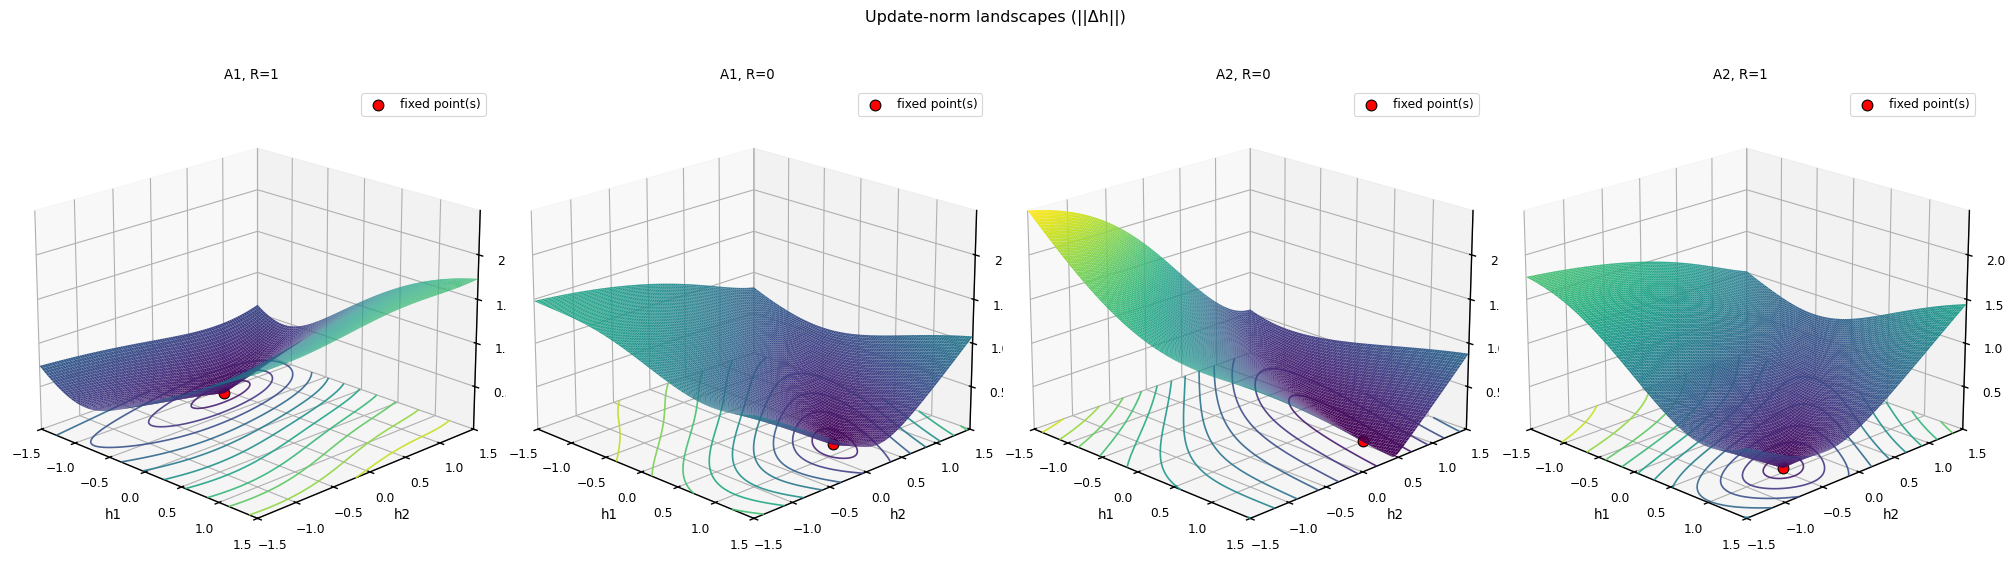

In [29]:
from matplotlib import cm
from matplotlib.colors import Normalize

# ---- 3D landscape plot of E(h) = ||Δh|| ----

def plot_gru_landscapes_3d(state_dict, 
                           inputs_dict,
                           grid_lim=1.5, grid_n=101,
                           title="Update-norm landscapes (||Δh||)"):
    """
    inputs_dict: {name: u_vector}, each u has shape (input_dim,)
    Plots one 3D surface per input (trial type) in a vertical column.
    Uses a shared colorbar with global min/max across panels.
    """
    P = unpack_gru_params(state_dict)
    H = P["Wh_r"].shape[1]
    assert H == 2, "This helper expects a 2-unit GRU (H=2)."

    # shared grid over hidden space
    xs = np.linspace(-grid_lim, grid_lim, grid_n)
    ys = np.linspace(-grid_lim, grid_lim, grid_n)
    X, Y = np.meshgrid(xs, ys)

    # compute Z (||Δh||) and fixed points for each input
    Zs = {}
    FPS = {}
    zmins = []
    zmaxs = []
    for name, u in inputs_dict.items():
        Z = np.zeros_like(X)
        for i in range(grid_n):
            for j in range(grid_n):
                h = np.array([X[i, j], Y[i, j]], dtype=float)
                dh = delta_field(h, u, P)
                Z[i, j] = np.linalg.norm(dh)
        Zs[name] = Z
        zmins.append(Z.min())
        zmaxs.append(Z.max())

        # fixed points for this input
        seeds = [np.array([x, y], float) for x in np.linspace(-grid_lim, grid_lim, 9)
                                       for y in np.linspace(-grid_lim, grid_lim, 9)]
        FPS[name] = find_fixed_points(P, u, seeds, alpha=0.7)

    # global normalization for shared colorbar
    vmin, vmax = min(zmins), max(zmaxs)
    norm = Normalize(vmin=vmin, vmax=vmax)

    n = len(inputs_dict)
    fig = plt.figure(figsize=(5*n,6))
    fig.suptitle(title, y=0.995)

    axes = []
    # create axes and plot each panel
    for idx, (name, u) in enumerate(inputs_dict.items(), start=1):
        ax = fig.add_subplot(1,n, idx, projection="3d")
        axes.append(ax)

        Z = Zs[name]
        facecolors = cm.viridis(norm(Z))
        ax.plot_surface(X, Y, Z, facecolors=facecolors,
                        rstride=1, cstride=1, linewidth=0,
                        antialiased=True, shade=False)

        # contours projected to base plane for readability
        zfloor = vmin  # project all contours to a common offset
        ax.contour(X, Y, Z, zdir='z', offset=zfloor, levels=12, cmap="viridis", alpha=0.9)

        # mark fixed points (if any) at the floor
        fps = FPS[name]
        if fps is not None and len(fps):
            ax.scatter(fps[:,0], fps[:,1], zs=zfloor, zdir='z',
                       s=60, c="red", edgecolor="k",
                       depthshade=False, label="fixed point(s)")
            ax.legend(loc="upper right")

        ax.set_title(f"{name}")
        ax.set_xlabel("h1")
        ax.set_ylabel("h2")
        ax.set_zlabel(r"$E(h)=\|\Delta h\|$")
        ax.set_xlim(-grid_lim, grid_lim)
        ax.set_ylim(-grid_lim, grid_lim)
        ax.set_zlim(vmin, vmax)
        ax.view_init(elev=20, azim=-45)

    # single shared colorbar
    mappable = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    mappable.set_array([])
    #cbar = fig.colorbar(mappable, ax=axes, shrink=0.6, pad=0.08)
    #cbar.set_label(r"$\|\Delta h\|$ (update magnitude)")

    plt.tight_layout(rect=(0, 0, 1, 0.98))
    return fig, axes

input_dict = {'A1, R=1':np.array([1,0]),
              'A1, R=0':np.array([0,0]),
              'A2, R=0':np.array([0,1]),
              'A2, R=1':np.array([1,1])}

plot_gru_landscapes_3d(weights,input_dict)

In [30]:
test = {}
if 'hello' in test.keys():
    print('hi')

## LSTM


## NM-RNN

Recall the equations here:

\begin{align}
z_t &= \tanh ( W_{zz}z_{t-1}+W_{iz} x_{t-1} ) && (\text{subnetwork state}) \\
h_t& =\tanh( W_{mod}h_{t-1}+W_{ih} x_{t-1} ) && (\text{hidden state}) \\
s_t &= \sigma(W_{zk} z_t+ b_k) && (\text{modulation gate}) \\
W_{mod}&=\sum_{k=1}^K s_{t,k}\cdot \mathcal{l}_k r_k^\top, \text{ where} \sum_{k=1}^K l_kr_k^\top  \approx W_{hh} && (\text{modulated recurrent weight})
\end{align}

However, we have quite a few variations, since we can vary the dimensionality of the subnetwork state /and/ the modulation. In particular, if the modulation has dimension 1, then $W_{mod}$ is a scaling of the first low rank component of $W_{hh}$.

### 1D

after analysing the 1D vanilla RNN and GRU, I'm expecting the gating mechanism here to essentially control switches from left to right (but not from right to left). It actually looks like it doesn't ! Instead it is the input which guides the dynamics of the network entirely!!

Index(['hidden_1', 'gate_subnetwork_1', 'gate_modulation_1', 'logit_value',
       'logit_past', 'logit_change', 'prob_A', 'prob_b', 'forced_choice',
       'choice', 'outcome', 'good_poke', 'session_trial_idx',
       'session_folder_name', 'trial_type', 'indices_train',
       'indices_validation', 'indices_evaluation'],
      dtype='object')


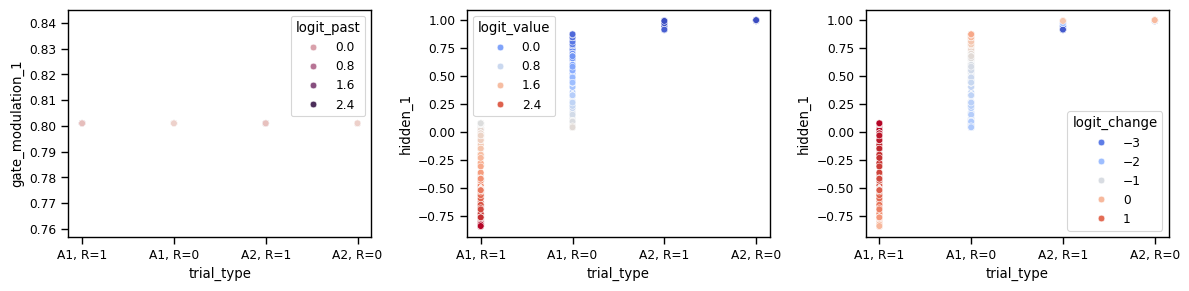

In [44]:
trials_df = model_dict['1_unit_NMRNN_1_subunits_1_low_rank']['trials_data']
print(trials_df.columns)
fig, ax = plt.subplots(1,3, figsize = (12,3))

sns.scatterplot(trials_df, x='trial_type',y='gate_modulation_1',
                hue = 'logit_past',ax = ax[0])
sns.scatterplot(trials_df, x='trial_type',y='hidden_1',
                hue = 'logit_value', palette = 'coolwarm', ax = ax[1],)
sns.scatterplot(trials_df, x='trial_type',y='hidden_1',
                hue = 'logit_change', palette = 'coolwarm', ax = ax[2],)
fig.tight_layout()

[Text(0.5, 1.0, '1D dynamical landscapes')]

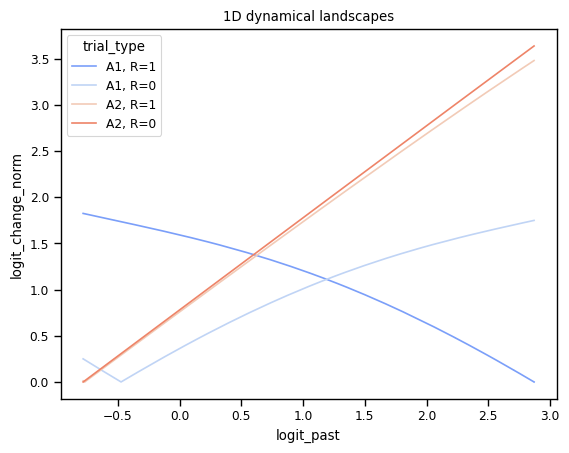

In [55]:
fig, ax = plt.subplots()
trials_df['logit_change_norm'] = np.abs(trials_df['logit_change'])
sns.lineplot(trials_df, x = 'logit_past',y='logit_change_norm',
             hue='trial_type', palette = 'coolwarm', ax  = ax)
ax.set(title = '1D dynamical landscapes')

## 2D

Here we have a lot of variety, so let's go through them one at a time

### 2 hidden units, 1 subnetwork unit and 1 modulation gate

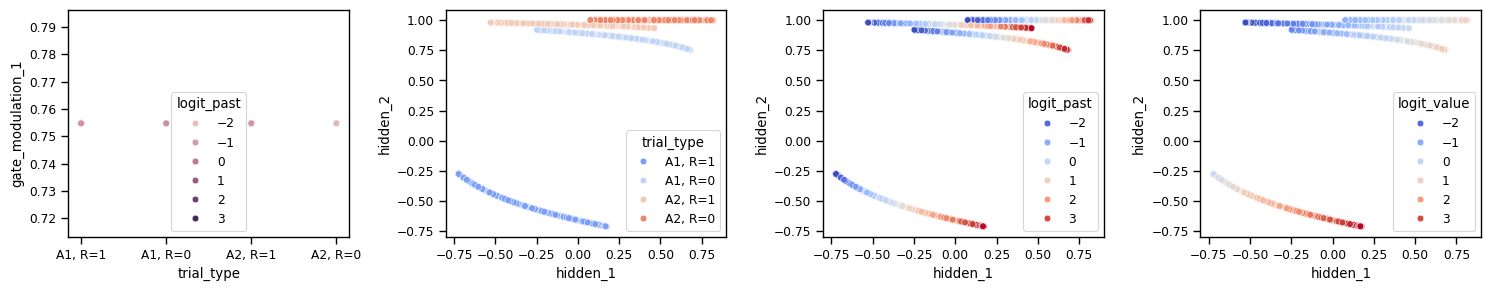

In [58]:
trials_df = model_dict['2_unit_NMRNN_1_subunits_1_low_rank']['trials_data']

fig, ax = plt.subplots(1,4, figsize = (15,3))

sns.scatterplot(trials_df, 
                x='trial_type',
                y='gate_modulation_1',
                hue = 'logit_past',ax = ax[0])
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2',
                hue = 'trial_type', palette = 'coolwarm', ax = ax[1],)
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2',
                hue = 'logit_past', palette = 'coolwarm', ax = ax[2],)
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2',
                hue = 'logit_value', palette = 'coolwarm', ax = ax[3],)
fig.tight_layout()


Here again we have a flat modulation which allows the network to gradually change its state given the inputs.


### 2 hidden units, 2 subnetwork units, and 1 modulation gate

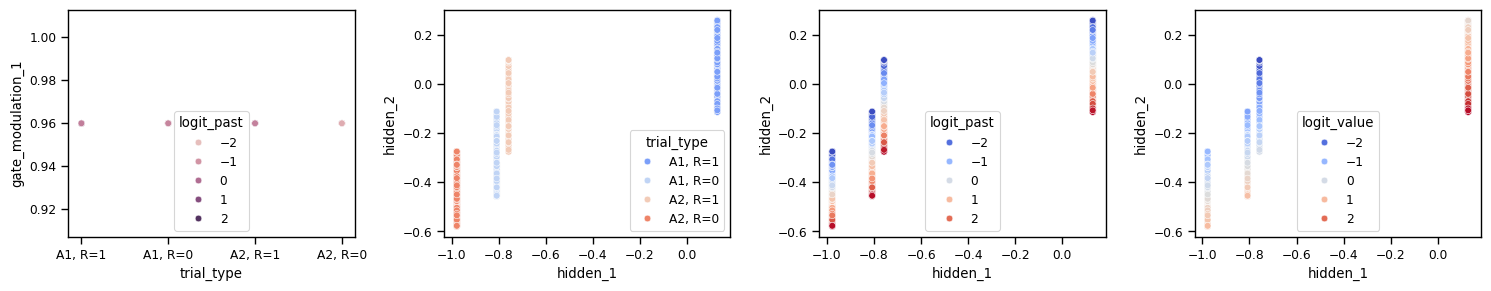

In [66]:
trials_df = model_dict['2_unit_NMRNN_2_subunits_1_low_rank']['trials_data']

fig, ax = plt.subplots(1,4, figsize = (15,3))

sns.scatterplot(trials_df, 
                x='trial_type',
                y='gate_modulation_1',
                hue = 'logit_past',ax = ax[0])
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2',
                hue = 'trial_type', palette = 'coolwarm', ax = ax[1],)
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2',
                hue = 'logit_past', palette = 'coolwarm', ax = ax[2],)
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2',
                hue = 'logit_value', palette = 'coolwarm', ax = ax[3],)
fig.tight_layout()


[Text(0.5, 1.0, '1D dynamical landscapes')]

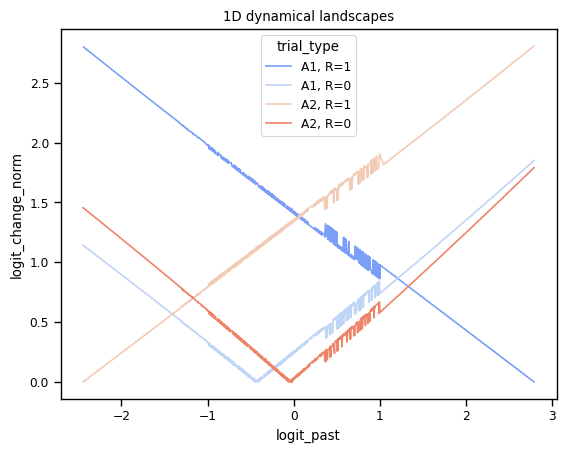

In [ ]:
fig, ax = plt.subplots()
trials_df['logit_change_norm'] = np.abs(trials_df['logit_change'])
sns.lineplot(trials_df, x = 'logit_past',y='logit_change_norm',
             hue='trial_type', palette = 'coolwarm', ax  = ax)
ax.set(title = '1D dynamical landscapes')

### 2 hidden units, 2 subnetwork units, 2 modulation gates

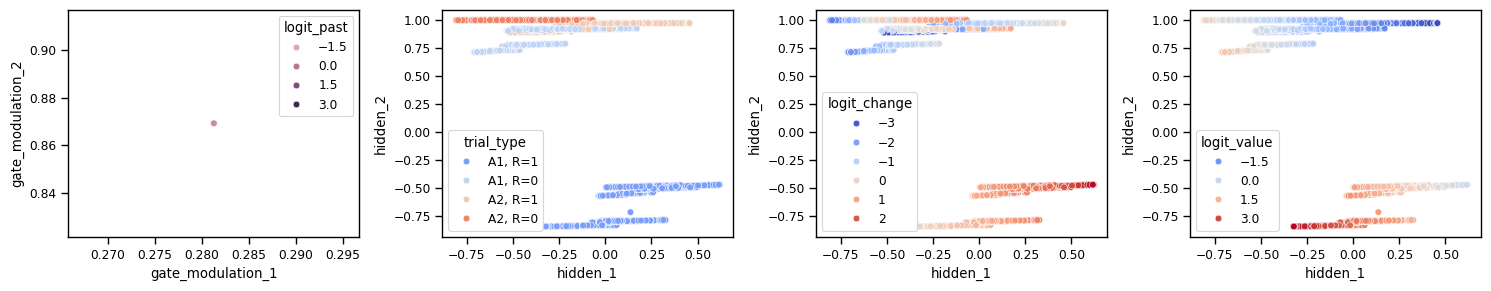

In [76]:
trials_df = model_dict['2_unit_NMRNN_2_subunits_2_low_rank']['trials_data']

fig, ax = plt.subplots(1,4, figsize = (15,3))

sns.scatterplot(trials_df, 
                x='gate_modulation_1',
                y='gate_modulation_2',
                hue = 'logit_past',ax = ax[0])
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2',
                hue = 'trial_type', palette = 'coolwarm', ax = ax[1],)
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2',
                hue = 'logit_change', palette = 'coolwarm', ax = ax[2],)
sns.scatterplot(trials_df, x='hidden_1',y='hidden_2',
                hue = 'logit_value', palette = 'coolwarm', ax = ax[3],)
fig.tight_layout()
